# Project 3 - Supervised Machine Learning - Classification

# Objective

The main objective of my analysis is to focus on **prediction** of heart failure based on the dataset described

In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
data = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# EDA

In [3]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [4]:
for feature in data.columns:
    print(feature, ':', len(data[feature].unique()))

age : 47
anaemia : 2
creatinine_phosphokinase : 208
diabetes : 2
ejection_fraction : 17
high_blood_pressure : 2
platelets : 176
serum_creatinine : 40
serum_sodium : 27
sex : 2
smoking : 2
time : 148
DEATH_EVENT : 2


In [5]:
discrete_features, continuous_features = [], []
for feature in data.columns:
    if feature == 'DEATH_EVENT':
        label = ['DEATH_EVENT']
    elif len(data[feature].unique()) >= 10:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)

print('Discrete: ', discrete_features, '\n', 'Continuous', continuous_features)

Discrete:  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'] 
 Continuous ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


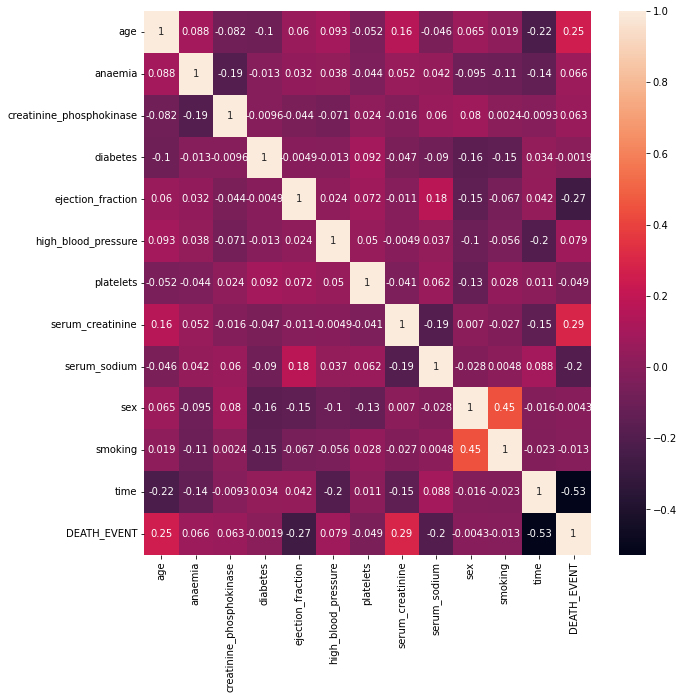

In [6]:
correlation = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

- There is nothing to conclude from discrete features correlation matrix.
- From the correlation matrix for continuous features, time is inversely correlated to death. Thus patients with less follow up time are prone to heart failure.

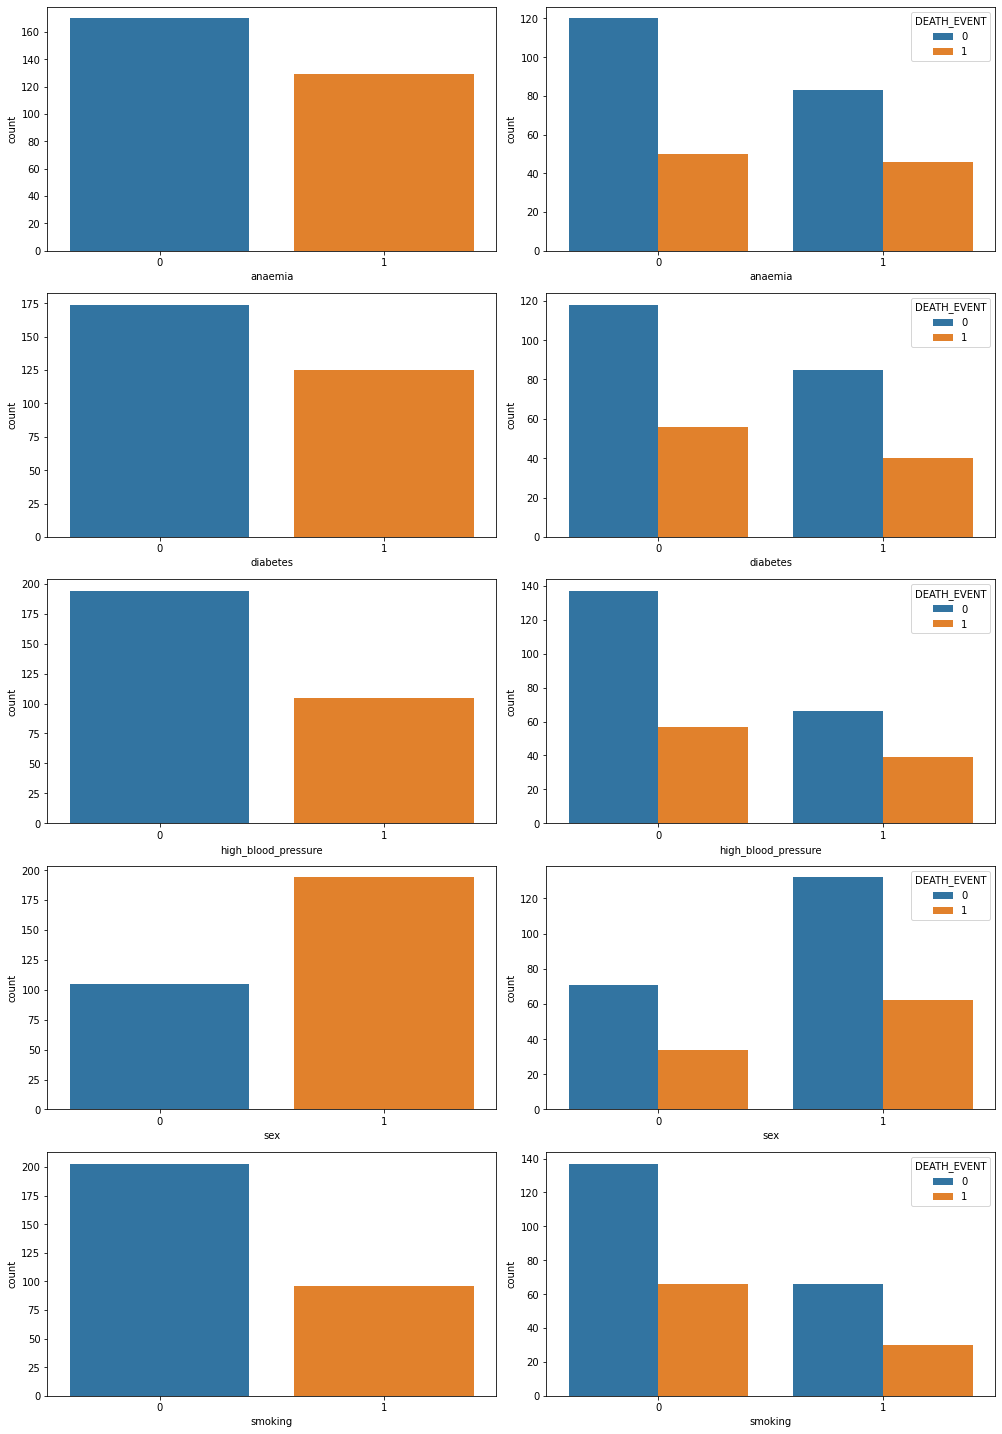

In [7]:
fig, ax = plt.subplots(len(discrete_features), 2, figsize=(14,20))

for i in range(len(discrete_features)):
    sns.countplot(ax=ax[i, 0], x=discrete_features[i], data=data)
    sns.countplot(ax=ax[i, 1], x=discrete_features[i], hue='DEATH_EVENT', data=data)
fig.tight_layout(pad=1)
plt.show()

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

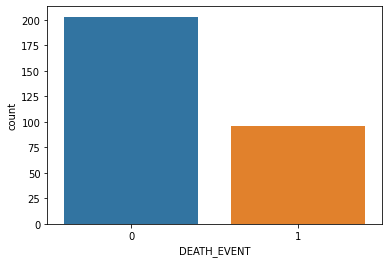

In [8]:
sns.countplot(x='DEATH_EVENT', data=data)

### Observations
- There is an imbalance with the target variable, so we can apply cross validation technique with over sampling method compared to under sampling as the data size is small.

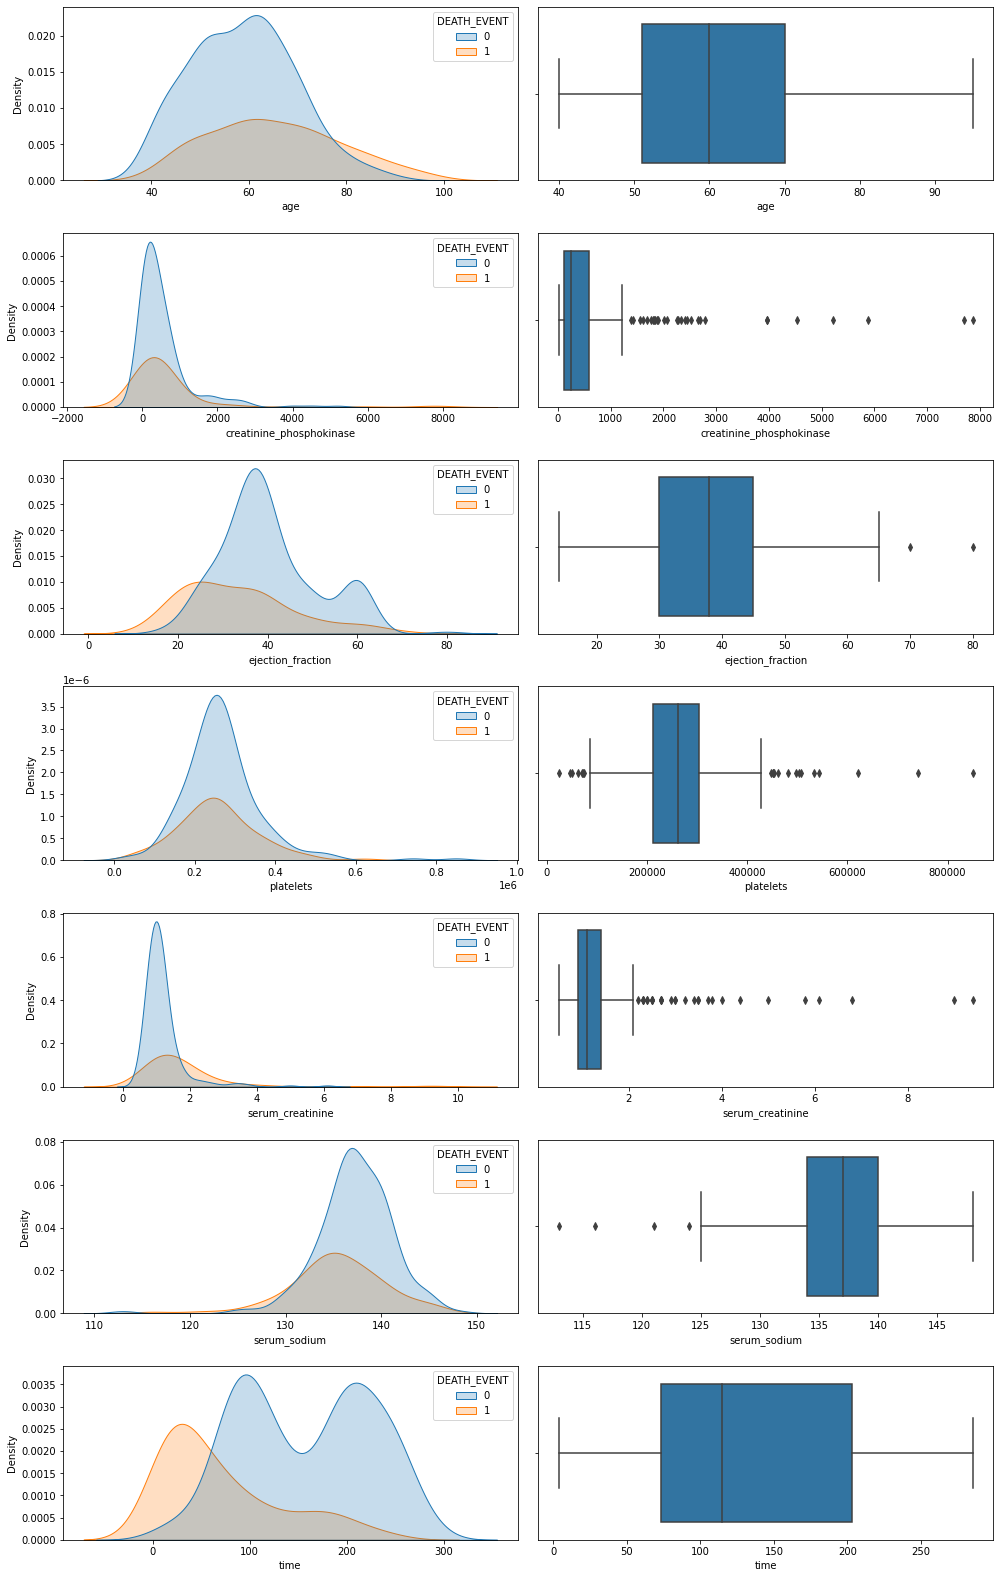

In [9]:
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(14,22))

for i in range(len(continuous_features)):
    sns.kdeplot(ax=ax[i, 0], x=continuous_features[i], hue='DEATH_EVENT', data=data, fill = True)
    sns.boxplot(ax=ax[i, 1], x=continuous_features[i], data=data)
fig.tight_layout(pad=1)
plt.show()

# Feature Selection

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import chi2, SelectFromModel, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
import xgboost

In [11]:
best_features = SelectKBest(chi2, k=10)
features_ranking = best_features.fit(data.drop(['DEATH_EVENT'], axis=1), data['DEATH_EVENT'])
ranking_dictionary = {}
for i in range(len(features_ranking.scores_)):
    ranking_dictionary[data.columns[i]] = round(features_ranking.scores_[i], 3)

asc_sort = sorted(ranking_dictionary.items(), key = lambda kv:(kv[1], kv[0]))

for i, j in asc_sort:
    print(i, ':', j)

diabetes : 0.001
sex : 0.002
smoking : 0.032
anaemia : 0.747
high_blood_pressure : 1.222
serum_sodium : 1.618
serum_creatinine : 19.814
age : 44.619
ejection_fraction : 79.073
creatinine_phosphokinase : 1897.315
time : 3826.893
platelets : 26135.772


In [12]:
feature_model = SelectFromModel(Lasso(alpha=0.05, random_state=0))
feature_model.fit(data.drop(['DEATH_EVENT'], axis=1), data['DEATH_EVENT'])

SelectFromModel(estimator=Lasso(alpha=0.05, random_state=0))

In [13]:
mask = feature_model.get_support() 
for i in range(len(mask)):
    if not mask[i]:
        print(data.drop(['DEATH_EVENT'], axis=1).columns[i])

anaemia
diabetes
high_blood_pressure
platelets
sex
smoking


### Observations
- Based on EDA and Feature Selection, features such as **anaemia, diabetes, age, sex, smoking** are less contributing.
- Features to be considered are, **platelets, time, creatinine_phosphokinase, ejection_fraction.**

### Romove Outliers

In [14]:
X = data.drop(['DEATH_EVENT'], axis=1)
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

(239, 12) (60, 12)


In [15]:
features_with_outliers = ['creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium']

In [16]:
lof = LocalOutlierFactor()
outlier_rows = lof.fit_predict(X_train)

mask = outlier_rows != -1
X_train, y_train = X_train[mask], y_train[mask]

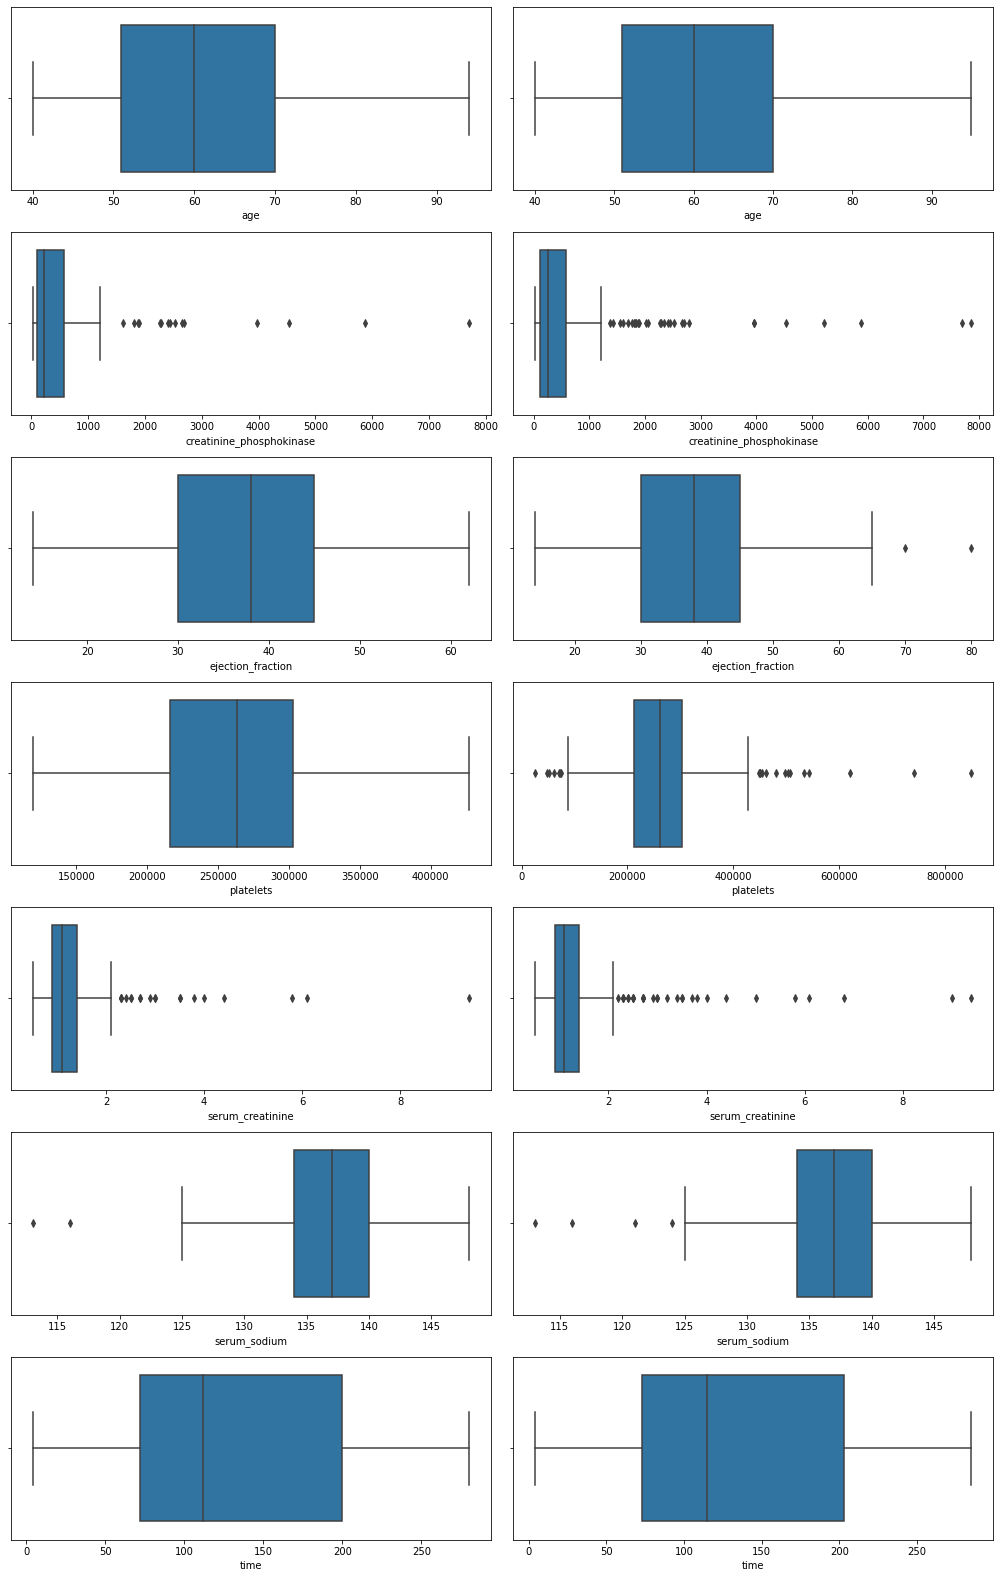

In [17]:
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(14,22))

for i in range(len(continuous_features)):
    sns.boxplot(ax=ax[i, 0], x=continuous_features[i], data=X_train)
    sns.boxplot(ax=ax[i, 1], x=continuous_features[i], data=data)
fig.tight_layout(pad=1)
plt.show()

# Model Building with SMOTE

In [39]:
X = data[['ejection_fraction', 'serum_creatinine', 'time']]
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lof = LocalOutlierFactor()
outlier_rows = lof.fit_predict(X_train)

mask = outlier_rows != -1
X_train, y_train = X_train[mask], y_train[mask]

oversample = SMOTE(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The accuracy of Logistic Regression is :  81.66666666666667 %
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        37
           1       0.77      0.74      0.76        23

    accuracy                           0.82        60
   macro avg       0.81      0.80      0.80        60
weighted avg       0.82      0.82      0.82        60



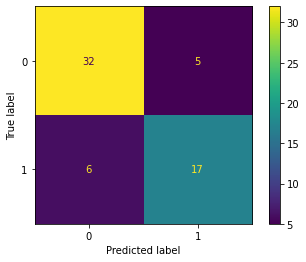

In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print ("The accuracy of Logistic Regression is : ", accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))

The accuracy of Random Forest is :  85.0 %
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        37
           1       0.85      0.74      0.79        23

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60



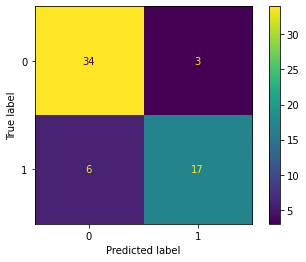

In [41]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print ("The accuracy of Random Forest is : ", accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))

The accuracy of Gradient Boost is :  90.0 %
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        37
           1       0.90      0.83      0.86        23

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.90      0.90        60



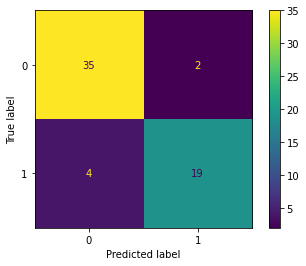

In [42]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print ("The accuracy of Gradient Boost is : ", accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))

# Best Model to Choose

| Models              | Accuracy | Recall |
|---------------------|----------|--------|
| Logistic Regression |   82%    |  81%   |
| Random Forest       |   85%    |  83%   |
| Gradient Boosting   |   90%    |  89%   |

Based on both accuracy and recall score, **Gradient Boosting** outperformed other algorithms. The reason for considering recall score here is, the data and prediction to be made about heart failure and in such case less False Negatives is to be predicted and to calculate it with proportion I have used **Recall Score**.

# Future Scope

- Ahead while revisiting the model again, I have plans to do more in-depth analysis of the data. 
- To add additional derived features to the data based on analysis.
- Can try different classifiers to train the model and also few ensemble methods as well to see any improvement.